# <Hsuan-You (Shaun) Lin / hl116 / **HW4**>

### Introduction
This assignment will introduce you to PyTorch and neural networks. We have provided a Colab notebook [located here](https://colab.research.google.com/drive/1rMHjwEPyu3eOvdTV8OUpPjFF5VW-zv9N?usp=sharing) with skeleton code to get you started. Colab comes with a free GPU. To activate the GPU during your session, click Runtime on the top toolbar, followed by Change runtime type, and select GPU under hardware accelerator. You will find the GPU useful for quickly training your neural network in Problem 2. 

# 1.0 PyTorch (10 points)
In this problem, you will perform some basic operations in PyTorch, including creating tensors, moving arrays between PyTorch and Numpy, and using autograd. **Before starting, please read the following pages:**
1. [Tensor basics](https://pytorch.org/tutorials/beginner/basics/tensorqs_tutorial.html)
2. [Autograd basics](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html), these two sections:
  
  a. Differentiation in Autograd
  
  b. Vector Calculus using autograd

In [1]:
import numpy as np
import imageio
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
from torch.utils.data import Dataset
from torchvision import transforms as T

from sklearn.metrics import confusion_matrix
from collections import defaultdict
from sklearn.metrics import ConfusionMatrixDisplay

from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/MyDrive/Colab Notebooks/COMP546/HW/HW4/"

Mounted at /content/drive


## 1.1 Basics of Autograd (5 points)
a.In the provided notebook, fill in the function **sin_taylor()** with code to approximate the value of the **sine** function using the Taylor approximation ([defined here](https://en.wikipedia.org/wiki/Taylor_series#:~:text=The%20sine%20function%20(blue)%20is,higher%20degree%20provide%20worse%20approximations.)). You can use **numpy.math.factorial()** to help you.

In [2]:
"""
Taylor approximation to sin(x). 
x: (float) Input value
n: (int) Number of terms in Taylor approximation
"""
def sin_taylor(x, n=10):
  # Initialize the sum to zero
  sum = 0.0
  # Loop over the number of terms in the Taylor series
  for i in range(n):
    # Compute the numerator and denominator of the ith term
    numerator = (-1) ** i * x ** (2 * i + 1)
    denominator = np.math.factorial(2 * i + 1)
    # Add the ith term to the sum
    sum += numerator / denominator
  return sum

b. Create a tensor **x** with value 𝜋/4 . Create a new tensor **y = sin_taylor(x)**. Use **y.backward()** to evaluate the gradient of y at x. Is this value a close approximation to the exact derivative of **sine** at **x**?

In [3]:
# Create a tensor x with value 𝜋/4
x = torch.tensor([np.pi/4], requires_grad=True)
# Create a new tensor y = sin_taylor(x)
y = sin_taylor(x)
# Use y.backward() to evaluate the gradient of y at x
y.backward()

# Print the gradient of y at x
print(x.grad) # Output: tensor([0.7071])

tensor([0.7071])


c. Now, create a NumPy array **x_npy** of 100 random numbers drawn uniformly from [−𝜋, 𝜋] (use [np.random.uniform](https://numpy.org/doc/stable/reference/random/generated/numpy.random.uniform.html)). Create a tensor **x** from that array and place the tensor onto the GPU. Again, evaluate **y = sin_taylor(x)**. This time, **y** is a vector. If you run **y.backward()**, it will throw an error because **autograd** is meant to evaluate the derivative of a scalar output with respect to input vectors (see tutorial pages above). Instead, run either one of these two lines (they do the same thing):

      y.sum().backward()
      y.backward(gradient=torch.ones(100)) 

What is happening here? We are creating a ‘dummy’ scalar output (let’s call it **z**), which contains the sum of values in **y**, and acts as the final scalar output of our computation graph. Due to the chain rule of differentiation, **dz/dx** will yield the same value as **dy/dx**.

In [4]:
# Create a NumPy array x_npy of 100 random numbers drawn uniformly from [-pi, pi]
x_npy = np.random.uniform(-np.pi, np.pi, size=(100,))

# Create a PyTorch tensor x from that array and place the tensor onto the GPU
x = torch.tensor(x_npy, requires_grad=True)

# Evaluate y = sin_taylor(x)
y = sin_taylor(x)

# Compute the sum of y and backpropagate to get dz/dx
y.sum().backward()
dz_dx = x.grad.numpy()

d. Get the gradient tensor **dz/dx** and convert that tensor to a Numpy array. Plot **dz/dx** vs. **x_npy**, overlaid on a cosine curve. Confirm that the points fall on the curve and put this plot in your report.

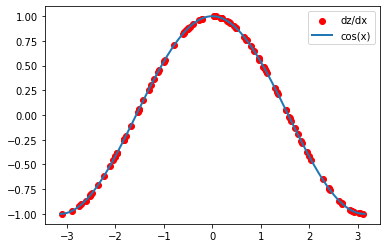

In [5]:
# Create an array of x values for plotting
x_plot = np.linspace(-np.pi, np.pi, num=100)

# Plot dz/dx and cosine curve
plt.scatter(x_npy, dz_dx, label='dz/dx', color = 'red')
plt.plot(x_plot, np.cos(x_plot), label='cos(x)', linewidth = 2)
plt.legend()
plt.show()

## 1.2 Image Denoising (5 points)
In this problem, you will denoise [this noisy parrot image](https://drive.google.com/file/d/1hkRGTdN6heiCRkZQiX08sJmYOomBBRTw/view?usp=share_link), which we denote I. To do so, you will create a denoising loss function, and use autograd to optimize the pixels of a new image J, which will be a denoised version of I.

a. In your Colab notebook, implement **denoising_loss()** to compute the following loss function:

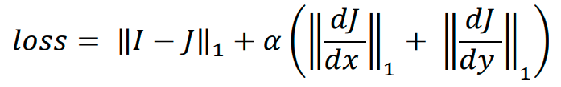

The first component is a data term making sure that the predicted image **J** is not too far from the original image **I**. The second term is a regularizer which will reward **J** if it is smoother, quantified using **J**’s spatial derivatives. We have provided you a function **get_spatial_gradients()** to compute the gradients.

In [6]:
"""
Returns the x and y gradient images for input image I. 
Input:
I: (Tensor) Image of shape (H, W, 3)

Output:
(Ix, Iy): (Tensor) Gradient images each of shape (H, W, 3)
"""
def get_spatial_gradients(I):
  I = I.permute(2, 0, 1).unsqueeze(0) # Change I's shape from (H, W, 3) to (1, 3, H, W)
  kx = torch.zeros(I.shape[1], I.shape[1], 3, 3).to(I.device)
  ky = torch.zeros(I.shape[1], I.shape[1], 3, 3).to(I.device)

  for i in range(3):
    kx[i, i, 1, 1] = -1
    kx[i, i, 1, 2] = 1
    ky[i, i, 1, 1] = -1
    ky[i, i, 2, 1] = 1

  Ix = F.conv2d(I, kx, padding=1)
  Iy = F.conv2d(I, ky, padding=1)
  return Ix[0,...].permute(1,2,0), Iy[0,...].permute(1,2,0)

"""
Denoising objective function.
Input:
I, J: (Tensor) Images of shape (H, W, 3)
alpha: (float) Regularization hyperparameter

Output:
loss: (float)
"""
def denoising_loss(I, J, alpha):
  # Compute data term
  data_term = torch.sum(torch.abs(I - J))

  # Compute regularizer term
  Ix, Iy = get_spatial_gradients(J)
  reg_term = torch.sum(torch.abs(Ix)) + torch.sum(torch.abs(Iy))

  # Combine terms
  loss = data_term + alpha * reg_term
  return loss

b. Implement gradient descent to optimize the pixels of **J** using your loss function and **autograd**. Initialize **J** to be a copy of **I**. Try different values for the learning rate and 𝛼 and find a combination that does a good job. Put the smoothed image **J**, along with the learning rate and 𝛼 you used in your report.

<ipython-input-7-36a400a3bc17>:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(path + 'parrot_noisy.png')/255.0


<Figure size 432x288 with 0 Axes>

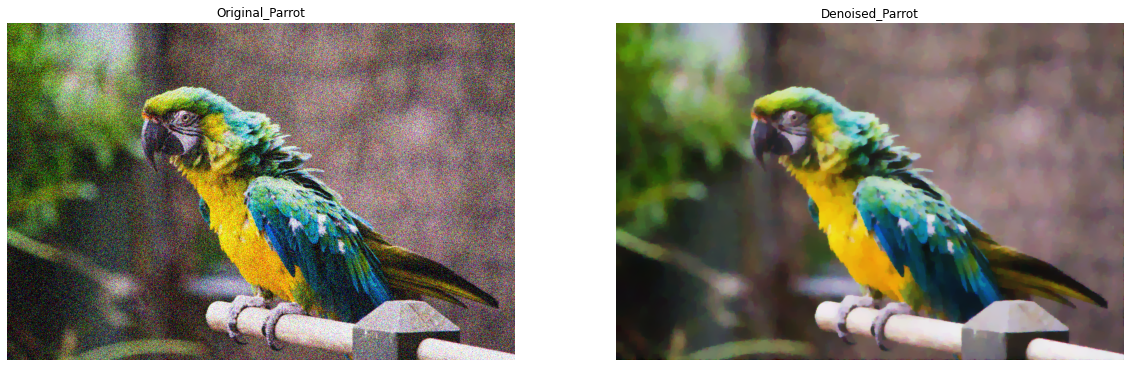

In [7]:
img = imageio.imread(path + 'parrot_noisy.png')/255.0
I = torch.tensor(img, dtype=torch.float32)
I = I.to('cuda')

lr = 0.9 # Learning rate
alpha = 1.5 # alpha
n_iter = 1000 # Number of iterations

# Initialize J to be a copy of I, with requires_grad_ set to True so that gradients can be computed
J = I.clone().requires_grad_(True)

# Run the optimization loop
for i in range(n_iter):
  # Compute loss and gradients
  loss = denoising_loss(I, J, alpha)
  loss.sum().backward()
  grad = J.grad

  # Normalize the gradient
  grad /= torch.norm(grad)

  # Update J by taking a gradient descent step
  with torch.no_grad():
    J -= lr * grad

  # Reset the gradient for J to zero
  J.grad.zero_()

# Convert the denoised image tensor J to a NumPy array, and move both J and I back to the CPU
J = J.detach().cpu( ).numpy()
I = I.detach().cpu().numpy()

# Plot the original and denoised images side by side
plt.figure()
fig, ax = plt.subplots(1, 2, figsize=(20, 15)) 
output_images = [I, J]
titles = ['Original_Parrot', 'Denoised_Parrot']
index = 0
for i in range(2):
  ax[i].imshow(output_images[index])
  ax[i].axis('off')
  ax[i].set_title(f"{titles[index]}")
  index += 1

c. **ELEC/COMP 546 Only:** Change the loss function to use L2 norms instead of L1. Does it work better or worse? Why?

Hints (you should use all of these in your solution):


*   **torch.clone**: performs a deep copy of a tensor
*   To require storing gradients for a tensor **x**, use: **x.requires_grad_(True)**
*   In the code, you will see the statement **with torch.no_grad()**:. Any statements written within that block will not update the computation graph. Put your gradient descent step within that block, since that operation should not update the graph.
*   Remember to zero out the gradient buffer of **J** after each step using
**J.grad.zero_(**). 
*   Remember to normalize the gradient to a unit vector before using it in your
gradient descent step.
*   To plot an image in tensor J using matplotlib, you will have to first detach it from the computation graph (to not track its gradients), move it from the GPU to the CPU, and convert to a NumPy array. You can do this in one line with:

        J = J.detach().cpu().numpy().

In [8]:
def denoising_loss_L2(I, J, alpha):
  # Compute data term
  data_term = torch.linalg.matrix_norm(I - J, ord = 2)

  # Compute regularizer term
  Ix, Iy = get_spatial_gradients(J)
  reg_term = torch.linalg.matrix_norm(Ix, ord = 2) + torch.linalg.matrix_norm(Iy, ord = 2)

  # Combine terms
  loss = data_term + alpha * reg_term
  return loss

<ipython-input-9-68eb59cc5fe4>:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(path + 'parrot_noisy.png')/255.0


<Figure size 432x288 with 0 Axes>

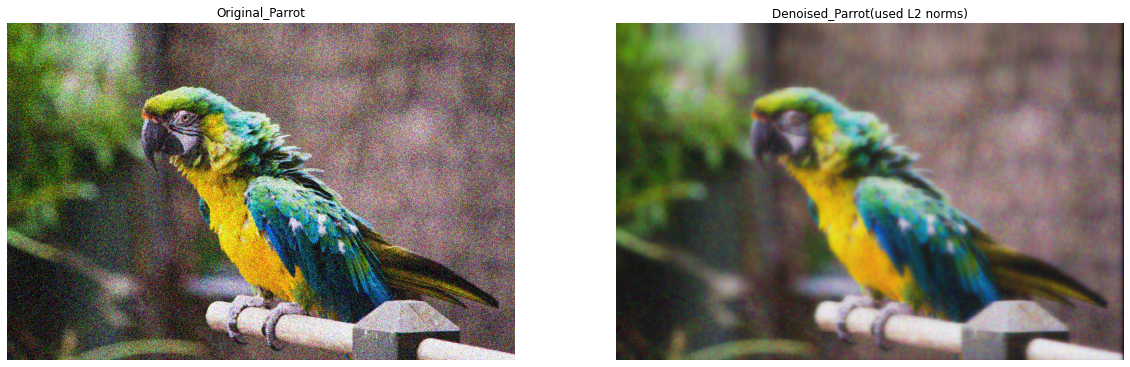

In [9]:
img = imageio.imread(path + 'parrot_noisy.png')/255.0
I = torch.tensor(img, dtype=torch.float32)
I = I.to('cuda')

lr = 0.9 # Learning rate
alpha = 1.5 # alpha
n_iter = 1000 # Number of iterations

# Initialize J to be a copy of I, with requires_grad_ set to True so that gradients can be computed
J = I.clone().requires_grad_(True)

# Run the optimization loop
for i in range(n_iter):
  # Compute loss and gradients
  loss = denoising_loss_L2(I, J, alpha)
  loss.sum().backward()
  grad = J.grad

  # Normalize the gradient
  grad /= torch.norm(grad)

  # Update J by taking a gradient descent step
  with torch.no_grad():
    J -= lr * grad

  # Reset the gradient for J to zero
  J.grad.zero_()

# Convert the denoised image tensor J to a NumPy array, and move both J and I back to the CPU
J = J.detach().cpu( ).numpy()
I = I.detach().cpu().numpy()

# Plot the original and denoised images side by side
plt.figure()
fig, ax = plt.subplots(1, 2, figsize=(20, 15)) 
output_images = [I, J]
titles = ['Original_Parrot', 'Denoised_Parrot(used L2 norms)']
index = 0
for i in range(2):
  ax[i].imshow(output_images[index])
  ax[i].axis('off')
  ax[i].set_title(f"{titles[index]}")
  index += 1

# 2.0 Training an image classifier (10 points)
In this problem, you will create and train your first neural network image classifier! Before starting this question, please read the following pages about training neural networks in PyTorch:

1. [Data loading](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)
2. [Models](https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html)
3. [Training loop](https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html)

We will be using the [CIFAR10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html), consisting of 60,000 images of 10 common classes. Each image is of size 32 x 32 x 3. Download the full dataset as one *.npz* file [here](https://drive.google.com/file/d/1sAiIwwdEInDfpKVPsdIu81tiOIZh0F3k/view?usp=share_link), and add it to your Google Drive. This file contains three objects: *X*: array of images, *y*: array of labels (specified as integers in [0,9]), and label_names: list of class names. Please complete the following:

a. Finish implementing the **CIFARDataset** class. See comments in the code for
further instructions. 

In [17]:
class CIFARDataset(Dataset):
  def __init__(self, images, labels, mode, transform):
    self.transform = transform

    if mode == 'train':
      self.images = images[:40000]
      self.labels = labels[:40000]

    elif mode == 'val':
      self.images = images[40000:50000]
      self.labels = labels[40000:50000] 
       
    elif mode == 'test':
      self.images = images[50000:]
      self.labels = labels[50000:]
      
    else:
      raise ValueError('Invalid mode!')

  def __getitem__(self, idx):
    # Do the following:
    # 1. Get the image and label from the dataset corresponding to index idx.
    image = self.images[idx]
    label = self.labels[idx]
    
    # 2. Convert the label to a LongTensor (needs to be of this type because it 
    # is an integer value and PyTorch will throw an error otherwise)
    label = torch.tensor(label, dtype=torch.long)

    # 3. Transform the image using self.transform. This will convert the image 
    # into a tensor, scale it to [0,1], and apply data augmentations.
    if self.transform is not None:
      image = self.transform(image)
    # 4. Return the image and label.   
    return image, label

  def __len__(self):
    # Return the length of the dataset
    return len(self.labels)

b. Add transforms: **RandomHorizontalFlip**, **RandomAffine** ([-5, 5] degree range, [0.8, 1.2] scale range) and **ColorJitter** ([0.8, 1.2] brightness range, [0.8, 1.2] saturation range). Don’t forget to apply the **ToTensor** transform first, which converts a H x W x 3 image to a 3 x H x W tensor, and normalizes the pixel range to [0,1]. You will find the transform APIs in [this page](https://pytorch.org/vision/0.9/transforms.html).

In [18]:
cifar = np.load(path + '/CIFAR.npz')
X, y, label_names = cifar['X'], cifar['y']*1.0, cifar['label_names']
print("Read in CIFAR10 dataset with %d examples, and labels:\n %s" % (X.shape[0], label_names))

batch_size = 64

# Define transforms
train_transform = T.Compose([
  T.ToTensor(),
  T.RandomHorizontalFlip(p=0.5),
  T.RandomAffine(degrees=(-5, 5), scale=(0.8, 1.2)),
  T.ColorJitter(brightness=(0.8, 1.2), saturation=(0.8, 1.2))
])

val_transform = T.Compose([
  T.ToTensor()
])

test_transform = T.Compose([
  T.ToTensor()
])

# transform = None # Add transforms.
train_dataset = CIFARDataset(X, y, "train", train_transform)
train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

# transform = None # No augmentations, but should still include ToTensor().
val_dataset = CIFARDataset(X, y, "val", val_transform)
val_dataloader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

# transform = None # No augmentations, but should still include ToTensor().
test_dataset = CIFARDataset(X, y, "test", test_transform)
test_dataloader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=1)

Read in CIFAR10 dataset with 60000 examples, and labels:
 ['airplane' 'automobile' 'bird' 'cat' 'deer' 'dog' 'frog' 'horse' 'ship'
 'truck']


c. Implement a CNN classifier with the structure in the following table. You will find the APIs for Conv, Linear, ReLU, and MaxPool in [this page](https://pytorch.org/docs/stable/nn.html). The spatial dimensions of an image should NOT change after a Conv operation (only after Maxpooling).

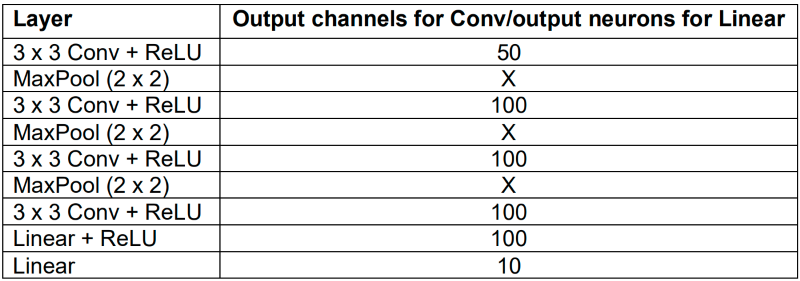

In [19]:
class Model(nn.Module):
  def __init__(self):
    super().__init__()
    # Define the layers
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=50, kernel_size=3, padding=1)
    self.relu1 = nn.ReLU()
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
    
    self.conv2 = nn.Conv2d(in_channels=50, out_channels=100, kernel_size=3, padding=1)
    self.relu2 = nn.ReLU()
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
    
    self.conv3 = nn.Conv2d(in_channels=100, out_channels=100, kernel_size=3, padding=1)
    self.relu3 = nn.ReLU()
    self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
    
    self.conv4 = nn.Conv2d(in_channels=100, out_channels=100, kernel_size=3, padding=1)
    self.relu4 = nn.ReLU()
    
    self.fc1 = nn.Linear(in_features=4*4*100, out_features=100)
    self.relu5 = nn.ReLU()
    
    self.fc2 = nn.Linear(in_features=100, out_features=10)
    
  def forward(self, x):
    # Pass the input through each layer in turn
    x = self.conv1(x)
    x = self.relu1(x)
    x = self.pool1(x)
    
    x = self.conv2(x)
    x = self.relu2(x)
    x = self.pool2(x)
    
    x = self.conv3(x)
    x = self.relu3(x)
    x = self.pool3(x)
    
    x = self.conv4(x)
    x = self.relu4(x)
    
    # Flatten the output of the final convolutional layer
    x = x.view(-1, 4*4*100)
    
    x = self.fc1(x)
    x = self.relu5(x)
    
    x = self.fc2(x)
    return x

d. Implement the training loop. 

e. Train your classifier for 15 epochs. The GPU, if accessible, will result in faster training. Make sure to save a model checkpoint at the end of each epoch, as you will use them in part f. Use the following training settings: batch size = 64, optimizer = Adam, learning rate = 1e-4.

In [20]:
lr = 1e-4

model = Model()
loss_fn = nn.CrossEntropyLoss()
model.to('cuda')

val_losses = []

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
for epoch in range(15):
  for batch, (X, y) in enumerate(train_dataloader):
    X = X.to('cuda')
    y = y.to('cuda')

    pred = model(X)
    loss = loss_fn(pred,y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 100 == 0:
      # print(epoch, batch, loss.item())
      print(f"Epoch {epoch+1}, Batch {batch}, Training Loss: {loss.item():.4f}")

  model.eval()

  loss = 0
  n_batches = 0
  for batch, (X, y) in enumerate(val_dataloader):
    X = X.to('cuda')
    y = y.to('cuda')

    with torch.no_grad():
      pred = model(X)
      loss += loss_fn(pred, y).item()
      n_batches += 1

  val_loss = loss / n_batches
  val_losses.append(val_loss)

  print(f"Epoch {epoch+1}, Validation Loss: {val_loss:.4f}")

  model_path = path + 'models/model_%d.params' %epoch
  torch.save(model.state_dict(), model_path)

<ipython-input-17-17a653dda315>:28: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)


Epoch 1, Batch 0, Training Loss: 2.2997
Epoch 1, Batch 100, Training Loss: 2.1528
Epoch 1, Batch 200, Training Loss: 1.9289
Epoch 1, Batch 300, Training Loss: 2.1588
Epoch 1, Batch 400, Training Loss: 1.6975
Epoch 1, Batch 500, Training Loss: 1.7223
Epoch 1, Batch 600, Training Loss: 1.7521


<ipython-input-17-17a653dda315>:28: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)


Epoch 1, Validation Loss: 1.6914


<ipython-input-17-17a653dda315>:28: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)


Epoch 2, Batch 0, Training Loss: 1.8616
Epoch 2, Batch 100, Training Loss: 1.6630
Epoch 2, Batch 200, Training Loss: 1.4850
Epoch 2, Batch 300, Training Loss: 1.6338
Epoch 2, Batch 400, Training Loss: 1.5441
Epoch 2, Batch 500, Training Loss: 1.5530
Epoch 2, Batch 600, Training Loss: 1.6114


<ipython-input-17-17a653dda315>:28: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)


Epoch 2, Validation Loss: 1.5688


<ipython-input-17-17a653dda315>:28: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)


Epoch 3, Batch 0, Training Loss: 1.5333
Epoch 3, Batch 100, Training Loss: 1.5267
Epoch 3, Batch 200, Training Loss: 1.5535
Epoch 3, Batch 300, Training Loss: 1.5786
Epoch 3, Batch 400, Training Loss: 1.5380
Epoch 3, Batch 500, Training Loss: 1.6648
Epoch 3, Batch 600, Training Loss: 1.5536


<ipython-input-17-17a653dda315>:28: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)


Epoch 3, Validation Loss: 1.4992


<ipython-input-17-17a653dda315>:28: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)


Epoch 4, Batch 0, Training Loss: 1.6292
Epoch 4, Batch 100, Training Loss: 1.4096
Epoch 4, Batch 200, Training Loss: 1.5395
Epoch 4, Batch 300, Training Loss: 1.5093
Epoch 4, Batch 400, Training Loss: 1.5191
Epoch 4, Batch 500, Training Loss: 1.4890
Epoch 4, Batch 600, Training Loss: 1.5462


<ipython-input-17-17a653dda315>:28: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)


Epoch 4, Validation Loss: 1.4260


<ipython-input-17-17a653dda315>:28: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)


Epoch 5, Batch 0, Training Loss: 1.5260
Epoch 5, Batch 100, Training Loss: 1.4821
Epoch 5, Batch 200, Training Loss: 1.3740
Epoch 5, Batch 300, Training Loss: 1.4220
Epoch 5, Batch 400, Training Loss: 1.5151
Epoch 5, Batch 500, Training Loss: 1.1479
Epoch 5, Batch 600, Training Loss: 1.3484


<ipython-input-17-17a653dda315>:28: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)


Epoch 5, Validation Loss: 1.3655


<ipython-input-17-17a653dda315>:28: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)


Epoch 6, Batch 0, Training Loss: 1.4287
Epoch 6, Batch 100, Training Loss: 1.4460
Epoch 6, Batch 200, Training Loss: 1.6332
Epoch 6, Batch 300, Training Loss: 1.2471
Epoch 6, Batch 400, Training Loss: 1.6181
Epoch 6, Batch 500, Training Loss: 1.1074
Epoch 6, Batch 600, Training Loss: 1.5050


<ipython-input-17-17a653dda315>:28: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)


Epoch 6, Validation Loss: 1.3111


<ipython-input-17-17a653dda315>:28: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)


Epoch 7, Batch 0, Training Loss: 1.4245
Epoch 7, Batch 100, Training Loss: 1.3743
Epoch 7, Batch 200, Training Loss: 1.5428
Epoch 7, Batch 300, Training Loss: 1.5553
Epoch 7, Batch 400, Training Loss: 1.1639
Epoch 7, Batch 500, Training Loss: 1.5920
Epoch 7, Batch 600, Training Loss: 1.2247


<ipython-input-17-17a653dda315>:28: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)


Epoch 7, Validation Loss: 1.2949


<ipython-input-17-17a653dda315>:28: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)


Epoch 8, Batch 0, Training Loss: 1.3797
Epoch 8, Batch 100, Training Loss: 1.2737
Epoch 8, Batch 200, Training Loss: 1.4288
Epoch 8, Batch 300, Training Loss: 1.2483
Epoch 8, Batch 400, Training Loss: 1.3157
Epoch 8, Batch 500, Training Loss: 1.2503
Epoch 8, Batch 600, Training Loss: 1.2536


<ipython-input-17-17a653dda315>:28: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)


Epoch 8, Validation Loss: 1.2499


<ipython-input-17-17a653dda315>:28: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)


Epoch 9, Batch 0, Training Loss: 1.3911
Epoch 9, Batch 100, Training Loss: 1.3528
Epoch 9, Batch 200, Training Loss: 1.2475
Epoch 9, Batch 300, Training Loss: 1.2598
Epoch 9, Batch 400, Training Loss: 1.3377
Epoch 9, Batch 500, Training Loss: 1.2252
Epoch 9, Batch 600, Training Loss: 1.1819


<ipython-input-17-17a653dda315>:28: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)


Epoch 9, Validation Loss: 1.2288


<ipython-input-17-17a653dda315>:28: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)


Epoch 10, Batch 0, Training Loss: 1.2661
Epoch 10, Batch 100, Training Loss: 1.2714
Epoch 10, Batch 200, Training Loss: 1.2533
Epoch 10, Batch 300, Training Loss: 1.3270
Epoch 10, Batch 400, Training Loss: 1.3605
Epoch 10, Batch 500, Training Loss: 1.2286
Epoch 10, Batch 600, Training Loss: 1.1654


<ipython-input-17-17a653dda315>:28: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)


Epoch 10, Validation Loss: 1.2231


<ipython-input-17-17a653dda315>:28: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)


Epoch 11, Batch 0, Training Loss: 1.0401
Epoch 11, Batch 100, Training Loss: 1.2736
Epoch 11, Batch 200, Training Loss: 1.1542
Epoch 11, Batch 300, Training Loss: 1.0411
Epoch 11, Batch 400, Training Loss: 1.2466
Epoch 11, Batch 500, Training Loss: 1.1057
Epoch 11, Batch 600, Training Loss: 1.2554


<ipython-input-17-17a653dda315>:28: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)


Epoch 11, Validation Loss: 1.1802


<ipython-input-17-17a653dda315>:28: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)


Epoch 12, Batch 0, Training Loss: 1.2078
Epoch 12, Batch 100, Training Loss: 1.1975
Epoch 12, Batch 200, Training Loss: 1.5593
Epoch 12, Batch 300, Training Loss: 1.2809
Epoch 12, Batch 400, Training Loss: 1.2883
Epoch 12, Batch 500, Training Loss: 1.1526
Epoch 12, Batch 600, Training Loss: 1.1314


<ipython-input-17-17a653dda315>:28: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)


Epoch 12, Validation Loss: 1.1370


<ipython-input-17-17a653dda315>:28: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)


Epoch 13, Batch 0, Training Loss: 1.2848
Epoch 13, Batch 100, Training Loss: 1.1667
Epoch 13, Batch 200, Training Loss: 1.1834
Epoch 13, Batch 300, Training Loss: 1.0634
Epoch 13, Batch 400, Training Loss: 1.1549
Epoch 13, Batch 500, Training Loss: 1.2185
Epoch 13, Batch 600, Training Loss: 1.2325


<ipython-input-17-17a653dda315>:28: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)


Epoch 13, Validation Loss: 1.1394


<ipython-input-17-17a653dda315>:28: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)


Epoch 14, Batch 0, Training Loss: 1.2708
Epoch 14, Batch 100, Training Loss: 1.2148
Epoch 14, Batch 200, Training Loss: 1.1577
Epoch 14, Batch 300, Training Loss: 1.1059
Epoch 14, Batch 400, Training Loss: 1.3236
Epoch 14, Batch 500, Training Loss: 1.1753
Epoch 14, Batch 600, Training Loss: 1.0020


<ipython-input-17-17a653dda315>:28: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)


Epoch 14, Validation Loss: 1.1182


<ipython-input-17-17a653dda315>:28: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)


Epoch 15, Batch 0, Training Loss: 1.2131
Epoch 15, Batch 100, Training Loss: 1.1885
Epoch 15, Batch 200, Training Loss: 0.9437
Epoch 15, Batch 300, Training Loss: 1.0947
Epoch 15, Batch 400, Training Loss: 1.3121
Epoch 15, Batch 500, Training Loss: 1.1630
Epoch 15, Batch 600, Training Loss: 0.9259


<ipython-input-17-17a653dda315>:28: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)


Epoch 15, Validation Loss: 1.0914


f. Compute validation loss per epoch and plot it. Which model will you choose and why?

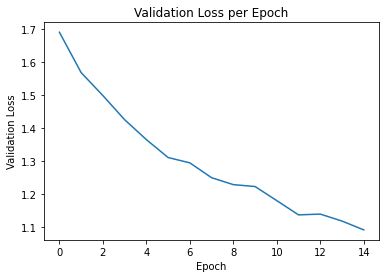

In [21]:
plt.plot(val_losses)
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss per Epoch')
plt.show()

g. Run the best model on your test set and report:



1.   Overall accuracy (# of examples correctly classified / # of examples)

In [23]:
# Apply the model to the test set
model = Model()
model.load_state_dict(torch.load(path+'models/model_14.params'))
model.to('cuda') 
model.eval()

# Create a dictionary to map class indices to names
class_names = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

y_true = []
y_pred = []

for X, y in test_dataloader:
    X = X.to('cuda')
    y = y.to('cuda')

    pred = model(X)
    _, pred_labels = torch.max(pred, dim=1)

    y_true += y.tolist()
    y_pred += pred_labels.tolist()

# Compute the overall accuracy
correct = 0
total = 0
for i in range(len(y_true)):
    if y_true[i] == y_pred[i]:
        correct += 1
    total += 1
overall_acc = correct / total
print('Overall accuracy: %.3f' % overall_acc)

<ipython-input-17-17a653dda315>:28: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)


Overall accuracy: 0.613


2.   Accuracy per class

In [24]:
# Compute the accuracy per class
acc_per_class = defaultdict(float)
count_per_class = defaultdict(int)
for true_label, pred_label in zip(y_true, y_pred):
    if true_label == pred_label:
        acc_per_class[true_label] += 1
    count_per_class[true_label] += 1

for i in range(10):
    if i in acc_per_class:
        acc_per_class[i] /= count_per_class[i]
    else:
        acc_per_class[i] = 0.0
    print('Accuracy for class %d (%s): %.3f' % (i, class_names[i], acc_per_class[i]))

Accuracy for class 0 (airplane): 0.671
Accuracy for class 1 (automobile): 0.645
Accuracy for class 2 (bird): 0.495
Accuracy for class 3 (cat): 0.342
Accuracy for class 4 (deer): 0.471
Accuracy for class 5 (dog): 0.566
Accuracy for class 6 (frog): 0.633
Accuracy for class 7 (horse): 0.725
Accuracy for class 8 (ship): 0.794
Accuracy for class 9 (truck): 0.789


3.   Confusion matrix: A 10 x 10 table, where the cell at row *i* and column *j* reports the fraction of times an example of class *i* was labeled by your model as class *j*. Please label the rows/columns by the object class name, not indices.

Class 0 (airplane): 0.671 0.024 0.060 0.011 0.007 0.009 0.006 0.015 0.124 0.073 
Class 1 (automobile): 0.050 0.645 0.011 0.007 0.000 0.005 0.007 0.008 0.041 0.226 
Class 2 (bird): 0.078 0.012 0.495 0.055 0.087 0.103 0.042 0.066 0.032 0.030 
Class 3 (cat): 0.024 0.011 0.095 0.342 0.063 0.243 0.061 0.073 0.029 0.059 
Class 4 (deer): 0.030 0.009 0.110 0.046 0.471 0.072 0.058 0.163 0.030 0.011 
Class 5 (dog): 0.014 0.003 0.082 0.132 0.043 0.566 0.015 0.106 0.017 0.022 
Class 6 (frog): 0.007 0.011 0.072 0.073 0.086 0.043 0.633 0.022 0.015 0.038 
Class 7 (horse): 0.021 0.004 0.025 0.035 0.045 0.081 0.004 0.725 0.005 0.055 
Class 8 (ship): 0.070 0.039 0.012 0.011 0.005 0.009 0.003 0.003 0.794 0.054 
Class 9 (truck): 0.039 0.082 0.009 0.006 0.003 0.007 0.014 0.017 0.034 0.789 


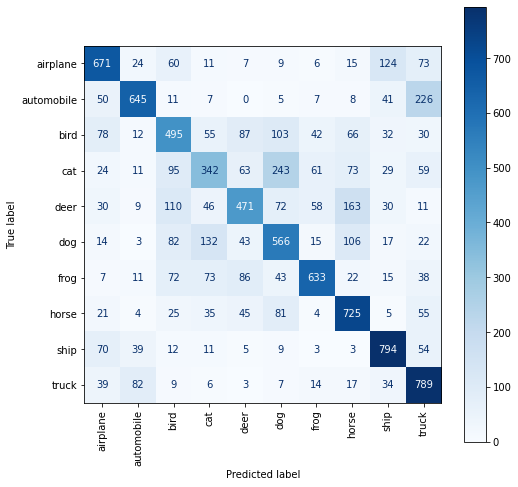

In [25]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
for i in range(10):
    row = 'Class %d (%s): ' % (i, class_names[i])
    for j in range(10):
        row += '%.3f ' % (conf_matrix[i][j] / count_per_class[i])
    print(row)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names.values())
disp.plot(include_values=True, cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')
plt.show()

4.   For the class on which your model has the worst accuracy (part 2), what is the other class it is most confused with? Show 5-10 test images that your model confused between these classes and comment on what factors may have caused the poor performance.

Class with worst accuracy: 3
Most confused with class: 5


<ipython-input-17-17a653dda315>:28: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)


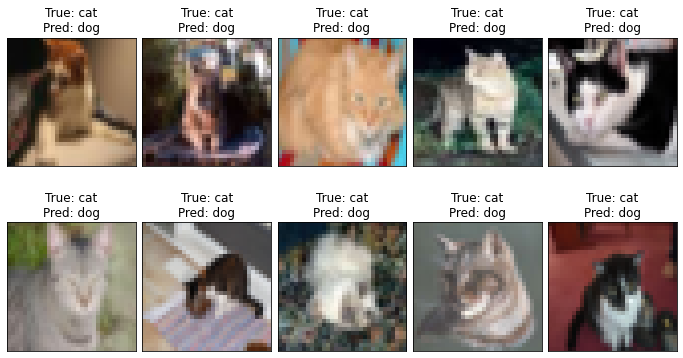

In [26]:
# Identify the class with the worst accuracy
worst_class = None
worst_acc = 1.0
for i in range(10):
    if acc_per_class[i] < worst_acc:
        worst_class = i
        worst_acc = acc_per_class[i]
print('Class with worst accuracy: %d' % worst_class)

# Identify the other class it is most confused with
worst_confusion = None
worst_confusion_rate = 0.0
for i in range(10):
    if i == worst_class:
        continue
    confusion_rate = conf_matrix[worst_class][i] / count_per_class[worst_class]
    if confusion_rate > worst_confusion_rate:
        worst_confusion = i
        worst_confusion_rate = confusion_rate
print('Most confused with class: %d' % worst_confusion)

# Show some example images that were confused between these classes

confused_images = []
for i in range(len(y_true)):
    if y_true[i] == worst_class and y_pred[i] == worst_confusion:
        confused_images.append((i, test_dataset[i][0], test_dataset[i][1]))

fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(12, 6),
                        subplot_kw={'xticks': [], 'yticks': []})
fig.subplots_adjust(hspace=0.3, wspace=0.05)

test_dataset.classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

for i, (idx, img, label) in zip(range(10), confused_images):
  axs[i//5, i%5].imshow(np.transpose(img, (1, 2, 0)))
  axs[i//5, i%5].set_title('True: %s\nPred: %s' % (test_dataset.classes[label], test_dataset.classes[worst_confusion]))

plt.show()

h. **ELEC/COMP 546 Only:** Change the last two Conv blocks in the architecture to Residual blocks and report overall accuracy of the best model. Recall that a residual block has the form:

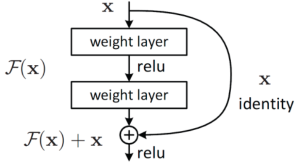

In [27]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1, bias=False)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        out = self.conv(x)
        out = self.relu(out)
        residual = x + out
        return residual
        

class ResidualModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Define the layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=50, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(in_channels=50, out_channels=100, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.resblock1 = ResBlock(in_channels=100, out_channels=100)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.resblock2 = ResBlock(in_channels=100, out_channels=100)
        
        self.fc1 = nn.Linear(in_features=4*4*100, out_features=100)
        self.relu3 = nn.ReLU()
        
        self.fc2 = nn.Linear(in_features=100, out_features=10)
        
    def forward(self, x):
        # Pass the input through each layer in turn
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        x = self.resblock1(x)
        x = self.pool3(x)
        x = self.resblock2(x)
        
        # Flatten the output of the final convolutional layer
        x = x.view(-1, 4*4*100)
        
        x = self.fc1(x)
        x = self.relu3(x)
        
        x = self.fc2(x)
        return x

In [28]:
lr = 1e-4

model = ResidualModel()
loss_fn = nn.CrossEntropyLoss()
model.to('cuda')

val_losses = []

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
for epoch in range(15):
    model.train()
    for batch, (X, y) in enumerate(train_dataloader):
        X = X.to('cuda')
        y = y.to('cuda')

        pred = model(X)
        loss = loss_fn(pred,y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            print(f"Epoch {epoch+1}, Batch {batch}, Training Loss: {loss.item():.4f}")

    model.eval()

    loss = 0
    n_batches = 0
    for batch, (X, y) in enumerate(val_dataloader):
        X = X.to('cuda')
        y = y.to('cuda')

        with torch.no_grad():
            pred = model(X)
            loss += loss_fn(pred, y).item()
            n_batches += 1

    val_loss = loss / n_batches
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}, Validation Loss: {val_loss:.4f}")

    model_path = path + 'models/residual_model_%d.params' %epoch
    torch.save(model.state_dict(), model_path)

<ipython-input-17-17a653dda315>:28: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)


Epoch 1, Batch 0, Training Loss: 2.3039
Epoch 1, Batch 100, Training Loss: 2.0849
Epoch 1, Batch 200, Training Loss: 1.9679
Epoch 1, Batch 300, Training Loss: 1.8298
Epoch 1, Batch 400, Training Loss: 1.7324
Epoch 1, Batch 500, Training Loss: 1.7829
Epoch 1, Batch 600, Training Loss: 1.7627


<ipython-input-17-17a653dda315>:28: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)


Epoch 1, Validation Loss: 1.6696


<ipython-input-17-17a653dda315>:28: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)


Epoch 2, Batch 0, Training Loss: 1.7197
Epoch 2, Batch 100, Training Loss: 1.7833
Epoch 2, Batch 200, Training Loss: 1.3918
Epoch 2, Batch 300, Training Loss: 1.4636
Epoch 2, Batch 400, Training Loss: 1.6178
Epoch 2, Batch 500, Training Loss: 1.5926
Epoch 2, Batch 600, Training Loss: 1.4503


<ipython-input-17-17a653dda315>:28: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)


Epoch 2, Validation Loss: 1.5358


<ipython-input-17-17a653dda315>:28: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)


Epoch 3, Batch 0, Training Loss: 1.6620
Epoch 3, Batch 100, Training Loss: 1.5866
Epoch 3, Batch 200, Training Loss: 1.2990
Epoch 3, Batch 300, Training Loss: 1.5014
Epoch 3, Batch 400, Training Loss: 1.4262
Epoch 3, Batch 500, Training Loss: 1.6229
Epoch 3, Batch 600, Training Loss: 1.4826


<ipython-input-17-17a653dda315>:28: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)


Epoch 3, Validation Loss: 1.4335


<ipython-input-17-17a653dda315>:28: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)


Epoch 4, Batch 0, Training Loss: 1.4397
Epoch 4, Batch 100, Training Loss: 1.1888
Epoch 4, Batch 200, Training Loss: 1.3871
Epoch 4, Batch 300, Training Loss: 1.5518
Epoch 4, Batch 400, Training Loss: 1.3392
Epoch 4, Batch 500, Training Loss: 1.3773
Epoch 4, Batch 600, Training Loss: 1.5299


<ipython-input-17-17a653dda315>:28: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)


Epoch 4, Validation Loss: 1.4476


<ipython-input-17-17a653dda315>:28: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)


Epoch 5, Batch 0, Training Loss: 1.6628
Epoch 5, Batch 100, Training Loss: 1.3864
Epoch 5, Batch 200, Training Loss: 1.3717
Epoch 5, Batch 300, Training Loss: 1.3751
Epoch 5, Batch 400, Training Loss: 1.3911
Epoch 5, Batch 500, Training Loss: 1.1877
Epoch 5, Batch 600, Training Loss: 1.4740


<ipython-input-17-17a653dda315>:28: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)


Epoch 5, Validation Loss: 1.3214


<ipython-input-17-17a653dda315>:28: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)


Epoch 6, Batch 0, Training Loss: 1.2193
Epoch 6, Batch 100, Training Loss: 1.3698
Epoch 6, Batch 200, Training Loss: 1.3279
Epoch 6, Batch 300, Training Loss: 1.6790
Epoch 6, Batch 400, Training Loss: 1.2576
Epoch 6, Batch 500, Training Loss: 1.2410
Epoch 6, Batch 600, Training Loss: 1.5793


<ipython-input-17-17a653dda315>:28: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)


Epoch 6, Validation Loss: 1.2886


<ipython-input-17-17a653dda315>:28: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)


Epoch 7, Batch 0, Training Loss: 1.1746
Epoch 7, Batch 100, Training Loss: 1.5944
Epoch 7, Batch 200, Training Loss: 1.4044
Epoch 7, Batch 300, Training Loss: 1.6421
Epoch 7, Batch 400, Training Loss: 1.5258
Epoch 7, Batch 500, Training Loss: 1.2688
Epoch 7, Batch 600, Training Loss: 1.1920


<ipython-input-17-17a653dda315>:28: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)


Epoch 7, Validation Loss: 1.3007


<ipython-input-17-17a653dda315>:28: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)


Epoch 8, Batch 0, Training Loss: 1.2914
Epoch 8, Batch 100, Training Loss: 1.3280
Epoch 8, Batch 200, Training Loss: 1.3329
Epoch 8, Batch 300, Training Loss: 1.0427
Epoch 8, Batch 400, Training Loss: 1.1136
Epoch 8, Batch 500, Training Loss: 1.1182
Epoch 8, Batch 600, Training Loss: 1.3841


<ipython-input-17-17a653dda315>:28: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)


Epoch 8, Validation Loss: 1.2335


<ipython-input-17-17a653dda315>:28: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)


Epoch 9, Batch 0, Training Loss: 1.1210
Epoch 9, Batch 100, Training Loss: 1.4103
Epoch 9, Batch 200, Training Loss: 1.2142
Epoch 9, Batch 300, Training Loss: 1.1823
Epoch 9, Batch 400, Training Loss: 1.1407
Epoch 9, Batch 500, Training Loss: 1.4750
Epoch 9, Batch 600, Training Loss: 1.3189


<ipython-input-17-17a653dda315>:28: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)


Epoch 9, Validation Loss: 1.2110


<ipython-input-17-17a653dda315>:28: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)


Epoch 10, Batch 0, Training Loss: 1.0921
Epoch 10, Batch 100, Training Loss: 1.2980
Epoch 10, Batch 200, Training Loss: 1.3054
Epoch 10, Batch 300, Training Loss: 1.3432
Epoch 10, Batch 400, Training Loss: 1.3010
Epoch 10, Batch 500, Training Loss: 1.1004
Epoch 10, Batch 600, Training Loss: 1.4363


<ipython-input-17-17a653dda315>:28: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)


Epoch 10, Validation Loss: 1.1565


<ipython-input-17-17a653dda315>:28: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)


Epoch 11, Batch 0, Training Loss: 1.2072
Epoch 11, Batch 100, Training Loss: 1.0582
Epoch 11, Batch 200, Training Loss: 1.3945
Epoch 11, Batch 300, Training Loss: 0.9900
Epoch 11, Batch 400, Training Loss: 1.0986
Epoch 11, Batch 500, Training Loss: 1.1895
Epoch 11, Batch 600, Training Loss: 1.2494


<ipython-input-17-17a653dda315>:28: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)


Epoch 11, Validation Loss: 1.1486


<ipython-input-17-17a653dda315>:28: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)


Epoch 12, Batch 0, Training Loss: 1.1433
Epoch 12, Batch 100, Training Loss: 1.2117
Epoch 12, Batch 200, Training Loss: 1.1385
Epoch 12, Batch 300, Training Loss: 1.1422
Epoch 12, Batch 400, Training Loss: 1.3678
Epoch 12, Batch 500, Training Loss: 1.1005
Epoch 12, Batch 600, Training Loss: 0.9867


<ipython-input-17-17a653dda315>:28: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)


Epoch 12, Validation Loss: 1.1195


<ipython-input-17-17a653dda315>:28: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)


Epoch 13, Batch 0, Training Loss: 1.0563
Epoch 13, Batch 100, Training Loss: 1.3340
Epoch 13, Batch 200, Training Loss: 1.0180
Epoch 13, Batch 300, Training Loss: 0.9455
Epoch 13, Batch 400, Training Loss: 1.1605
Epoch 13, Batch 500, Training Loss: 0.8051
Epoch 13, Batch 600, Training Loss: 1.0460


<ipython-input-17-17a653dda315>:28: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)


Epoch 13, Validation Loss: 1.1127


<ipython-input-17-17a653dda315>:28: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)


Epoch 14, Batch 0, Training Loss: 1.1869
Epoch 14, Batch 100, Training Loss: 1.3265
Epoch 14, Batch 200, Training Loss: 1.1907
Epoch 14, Batch 300, Training Loss: 1.3455
Epoch 14, Batch 400, Training Loss: 1.0060
Epoch 14, Batch 500, Training Loss: 1.0704
Epoch 14, Batch 600, Training Loss: 1.1675


<ipython-input-17-17a653dda315>:28: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)


Epoch 14, Validation Loss: 1.0523


<ipython-input-17-17a653dda315>:28: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)


Epoch 15, Batch 0, Training Loss: 1.1290
Epoch 15, Batch 100, Training Loss: 0.8210
Epoch 15, Batch 200, Training Loss: 0.9471
Epoch 15, Batch 300, Training Loss: 1.2354
Epoch 15, Batch 400, Training Loss: 0.9751
Epoch 15, Batch 500, Training Loss: 1.0797
Epoch 15, Batch 600, Training Loss: 1.0810


<ipython-input-17-17a653dda315>:28: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)


Epoch 15, Validation Loss: 1.0423


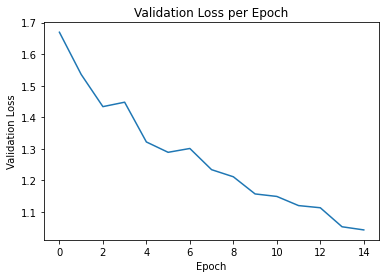

In [29]:
plt.plot(val_losses)
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss per Epoch')
plt.show()

In [30]:
# Apply the model to the test set
model = ResidualModel()
model.load_state_dict(torch.load(path+'models/residual_model_14.params'))
model.to('cuda') 
model.eval()

# Create a dictionary to map class indices to names
class_names = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

y_true = []
y_pred = []

for X, y in test_dataloader:
    X = X.to('cuda')
    y = y.to('cuda')

    pred = model(X)
    _, pred_labels = torch.max(pred, dim=1)

    y_true += y.tolist()
    y_pred += pred_labels.tolist()

# Compute the overall accuracy
correct = 0
total = 0
for i in range(len(y_true)):
    if y_true[i] == y_pred[i]:
        correct += 1
    total += 1
overall_acc = correct / total
print('Overall accuracy: %.3f' % overall_acc)

<ipython-input-17-17a653dda315>:28: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)


Overall accuracy: 0.635
